In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [ ]:
###

In [2]:
prediction_files = glob.glob("/Users/rezadoobary/Downloads/embeddings/train_6789_*/*.csv")
prediction_files = [f for f in prediction_files if 'pos' not in f]

In [3]:
prediction_files=[
 '/Users/rezadoobary/Downloads/embeddings/train_6789_test_9/helpful-sweep-260_9_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_6789_test_7/helpful-sweep-260_7_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_6789_test_6/helpful-sweep-260_6_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_6789_test_8/helpful-sweep-260_8_predictions.csv']

In [4]:
import pandas as pd
import numpy as np

dfs = []

# sort files by p value (as you already do)
sorted_files = np.array(prediction_files)[
    np.argsort([int(p.split('/')[5].split('_')[-1]) for p in prediction_files])
]

for p in sorted_files:
    df = pd.read_csv(p)
    p_value = int(p.split('/')[5].split('_')[-1])
    df["p"] = p_value
    dfs.append(df)

train_results = pd.concat(dfs, ignore_index=True)


In [5]:
files = glob.glob("/Users/rezadoobary/Downloads/embeddings/train_6789_*/embeddings.npy")
files = [f for f in files if 'pos' not in f]

In [6]:
test_embeddings = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_10/embeddings.npy")
test_predictions = pd.read_csv("/Users/rezadoobary/Downloads/embeddings/train_6789_test_10/helpful-sweep-260_10_predictions.csv")

embeddings_6 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_6/embeddings.npy")
embeddings_7 = np.load('/Users/rezadoobary/Downloads/embeddings/train_6789_test_7/embeddings.npy')
embeddings_8 = np.load('/Users/rezadoobary/Downloads/embeddings/train_6789_test_8/embeddings.npy')
embeddings_9 = np.load('/Users/rezadoobary/Downloads/embeddings/train_6789_test_9/embeddings.npy')

train_embeddings = np.vstack([
    embeddings_6,
    embeddings_7,
    embeddings_8,
    embeddings_9
])

print(train_embeddings.shape, test_embeddings.shape)

(15599, 128) (153252, 128)


In [7]:
# cosine sim


import numpy as np

def l2_normalize(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True) 

# normalize
train_norm = train_embeddings / np.linalg.norm(train_embeddings, axis=1, keepdims=True)
test_norm = test_embeddings / np.linalg.norm(test_embeddings, axis=1, keepdims=True)

import faiss

d = train_norm.shape[1]

index = faiss.IndexFlatIP(d)  # inner product
index.add(train_norm.astype("float32"))

sims, _ = index.search(test_norm.astype("float32"), 5)

test_predictions["max_cosine_sim"] = sims[:, 0]
test_predictions["top5_cosine_sim"] = sims.mean(axis=1)


In [91]:
import numpy as np
import faiss

train_norm = train_norm.astype("float32")
faiss.normalize_L2(train_norm)

d = train_norm.shape[1]
index = faiss.IndexFlatIP(d)   # IP = inner product
index.add(train_norm)
# Search train against itself
sims, idx = index.search(train_norm, k=2)
sims = sims[train_results[train_results['y_true'] == 1].index.values]

train_max_cosine = sims[:, 1]

cos_threshold = np.percentile(train_max_cosine, 5)

print(f"Cosine OOD threshold (5th percentile): {cos_threshold:.3f}")



Cosine OOD threshold (5th percentile): 0.990


In [92]:
def get_zero_fraction(temp, test_predictions):
    min_val = temp[temp['y_true'] == 1]['y_prob'].min()
    return min_val, (temp['y_prob'] < min_val).sum().item()/(test_predictions['y_true'] == 0).sum().item()

In [93]:
from sklearn.metrics import roc_auc_score

In [94]:
roc_auc_score(test_predictions['y_true'], test_predictions['y_prob']), get_zero_fraction(test_predictions, test_predictions)

(0.9697997488900569, (6.680335e-11, 0.3023855513829923))

In [95]:
temp = test_predictions[test_predictions['max_cosine_sim'] >= cos_threshold]
from sklearn.metrics import roc_auc_score

roc_auc_score(temp['y_true'], temp['y_prob']), get_zero_fraction(temp, test_predictions)

(0.9834111421399355, (6.680335e-11, 0.3023855513829923))

In [96]:
temp = test_predictions[test_predictions['max_cosine_sim'] < cos_threshold]
from sklearn.metrics import roc_auc_score
print(temp.shape)
roc_auc_score(temp['y_true'], temp['y_prob']), get_zero_fraction(temp,test_predictions)

(18084, 5)


(0.6964888953725391, (6.790928e-05, 0.00013726970555648157))

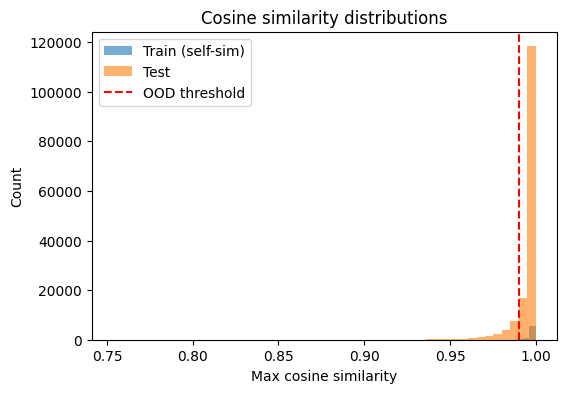

In [78]:
plt.figure(figsize=(6, 4))
plt.hist(train_max_cosine, bins=50, alpha=0.6, label="Train (self-sim)")
plt.hist(test_predictions['max_cosine_sim'].values, bins=50, alpha=0.6, label="Test")
plt.axvline(cos_threshold, color="red", linestyle="--", label="OOD threshold")
plt.xlabel("Max cosine similarity")
plt.ylabel("Count")
plt.legend()
plt.title("Cosine similarity distributions")
plt.show()


In [58]:
test_proj

array([[-1.0504539 ,  0.10997041],
       [-1.1049393 ,  0.24819009],
       [-1.062085  ,  0.060417  ],
       ...,
       [ 0.7760435 , -0.09146792],
       [ 0.8523467 ,  0.12510748],
       [ 0.8374139 ,  0.10383063]], shape=(153252, 2), dtype=float32)

In [9]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2, random_state=0)
pca.fit(train_embeddings)

train_proj = pca.transform(train_embeddings)
test_proj = pca.transform(test_embeddings)

p = test_predictions["y_prob"].values
entropy = -(p*np.log(p+1e-12) + (1-p)*np.log(1-p+1e-12))

entropy = entropy / np.log(p.shape)  # now in [0, 1]


p = train_results["y_prob"].values
train_entropy = -(p*np.log(p+1e-12) + (1-p)*np.log(1-p+1e-12))

train_entropy = train_entropy / np.log(p.shape)  # now in [0, 1]

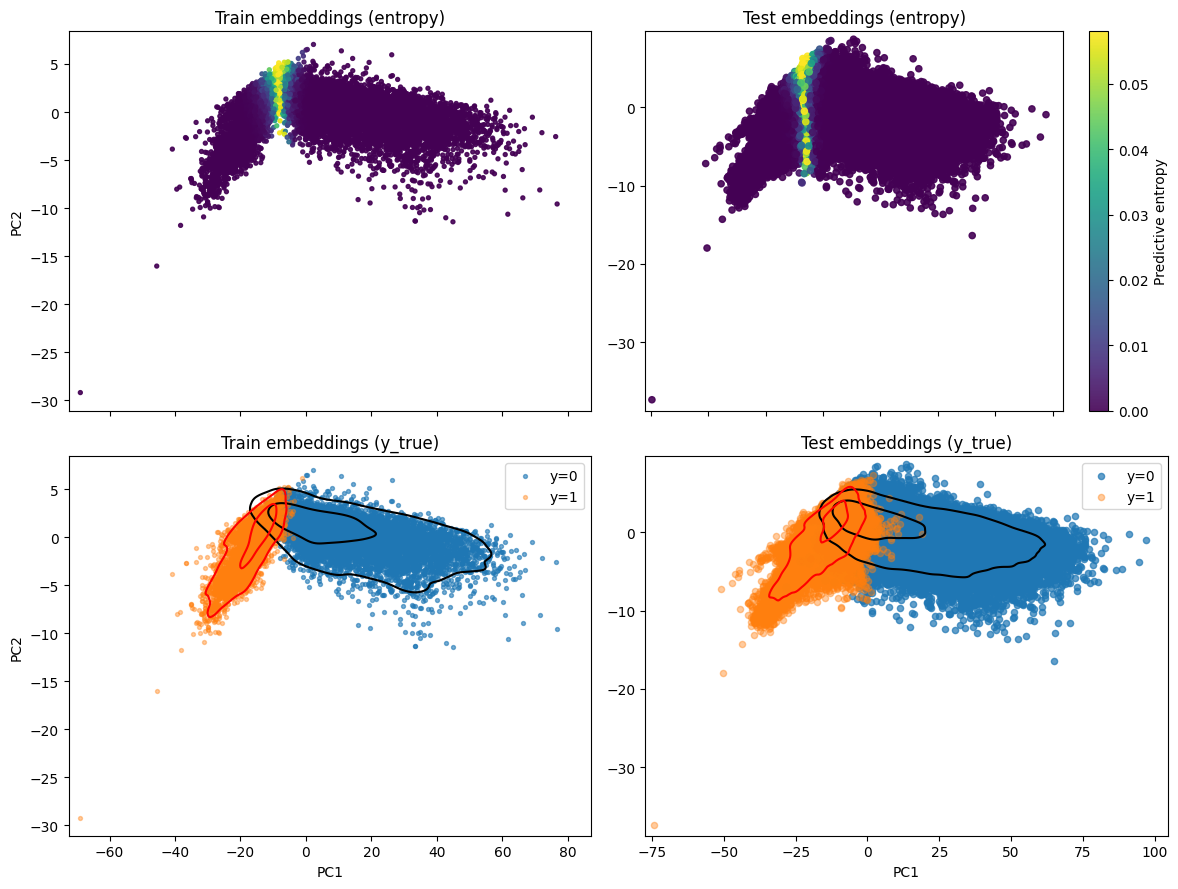

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex="col", sharey="col")

# =======================
# TOP ROW — your existing plots
# =======================
axes[0, 0].scatter(
    train_proj[:, 0],
    train_proj[:, 1],
    c=train_entropy,
    cmap="viridis",
    s=8,
    alpha=0.9
)
axes[0, 0].set_title("Train embeddings (entropy)")
axes[0, 0].set_ylabel("PC2")

sc = axes[0, 1].scatter(
    test_proj[:, 0],
    test_proj[:, 1],
    c=entropy,
    cmap="viridis",
    s=20,
    alpha=0.9
)
axes[0, 1].set_title("Test embeddings (entropy)")
plt.colorbar(sc, ax=axes[0, 1], label="Predictive entropy")

# =======================
# BOTTOM LEFT — Train PCA by y_true
# =======================
axes[1, 0].scatter(
    train_proj[train_results['y_true'] == 0, 0],
    train_proj[train_results['y_true'] == 0, 1],
    s=8,
    alpha=0.6,
    label="y=0"
)
axes[1, 0].scatter(
    train_proj[train_results['y_true'] == 1, 0],
    train_proj[train_results['y_true'] == 1, 1],
    s=8,
    alpha=0.4,
    label="y=1"
)
axes[1, 0].set_title("Train embeddings (y_true)")
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")
axes[1, 0].legend()

# =======================
# BOTTOM RIGHT — Test PCA by y_true
# =======================
axes[1, 1].scatter(
    test_proj[test_predictions['y_true'] == 0, 0],
    test_proj[test_predictions['y_true'] == 0, 1],
    s=20,
    alpha=0.7,
    label="y=0",
    
)
axes[1, 1].scatter(
    test_proj[test_predictions['y_true'] == 1, 0],
    test_proj[test_predictions['y_true'] == 1, 1],
    s=20,
    alpha=0.4,
    label="y=1",
)
axes[1, 1].set_title("Test embeddings (y_true)")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].legend()





import seaborn as sns

# Class 0
sns.kdeplot(
    x=train_proj[train_results["y_true"] == 0, 0],
    y=train_proj[train_results["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=0 density",
)

# Class 1
sns.kdeplot(
    x=train_proj[train_results["y_true"] == 1, 0],
    y=train_proj[train_results["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=1 density",
)





# Class 0
sns.kdeplot(
    x=test_proj[test_predictions["y_true"] == 0, 0],
    y=test_proj[test_predictions["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 1]
)

# Class 1
sns.kdeplot(
    x=test_proj[test_predictions["y_true"] == 1, 0],
    y=test_proj[test_predictions["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 1]
)

plt.tight_layout()
plt.show()


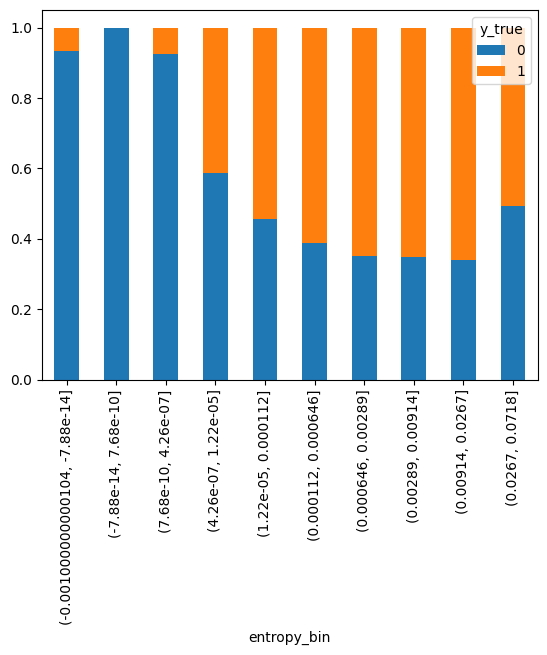

In [13]:
train_results["entropy_bin"] = pd.qcut(train_results["entropy"], 10)

pd.crosstab(
    train_results["entropy_bin"],
    train_results["y_true"],
    normalize="index"
).plot(kind="bar", stacked=True)
plt.show()

In [31]:
prediction_files

['/Users/rezadoobary/Downloads/embeddings/train_678910_test_7/devoted-sweep-14_7_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_678910_test_9/devoted-sweep-14_9_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_678910_test_8/devoted-sweep-14_8_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_678910_test_6/devoted-sweep-14_6_predictions.csv',
 '/Users/rezadoobary/Downloads/embeddings/train_678910_test_11/devoted-sweep-14_11_predictions.csv']

In [ ]:
# let's see this in 11 loops
prediction_files = glob.glob("/Users/rezadoobary/Downloads/embeddings/train_678910_*/*.csv")
prediction_files = [f for f in prediction_files if 'pos' not in f]


test_embeddings = np.load("/Users/rezadoobary/Downloads/embeddings/train_678910_test_11/embeddings.npy")
test_predictions = pd.read_csv("/Users/rezadoobary/Downloads/embeddings/train_678910_test_11/devoted-sweep-14_11_predictions.csv")

embeddings_6 = np.load("/Users/rezadoobary/Downloads/embeddings/train_678910_test_6/embeddings.npy")
embeddings_7 = np.load('/Users/rezadoobary/Downloads/embeddings/train_678910_test_7/embeddings.npy')
embeddings_8 = np.load('/Users/rezadoobary/Downloads/embeddings/train_678910_test_8/embeddings.npy')
embeddings_9 = np.load('/Users/rezadoobary/Downloads/embeddings/train_678910_test_9/embeddings.npy')

train_embeddings = np.vstack([
    embeddings_6,
    embeddings_7,
    embeddings_8,
    embeddings_9
])

print(train_embeddings.shape, test_embeddings.shape)


(15599, 64) (1697302, 64)


In [38]:
test_predictions = test_predictions.sample(100000)

In [42]:
test_embeddings = test_embeddings[test_predictions.index.values]

In [43]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2, random_state=0)
pca.fit(train_embeddings)

train_proj = pca.transform(train_embeddings)
test_proj = pca.transform(test_embeddings)

p = test_predictions["y_prob"].values
entropy = -(p*np.log(p+1e-12) + (1-p)*np.log(1-p+1e-12))

entropy = entropy / np.log(p.shape)  # now in [0, 1]


p = train_results["y_prob"].values
train_entropy = -(p*np.log(p+1e-12) + (1-p)*np.log(1-p+1e-12))

train_entropy = train_entropy / np.log(p.shape)  # now in [0, 1]

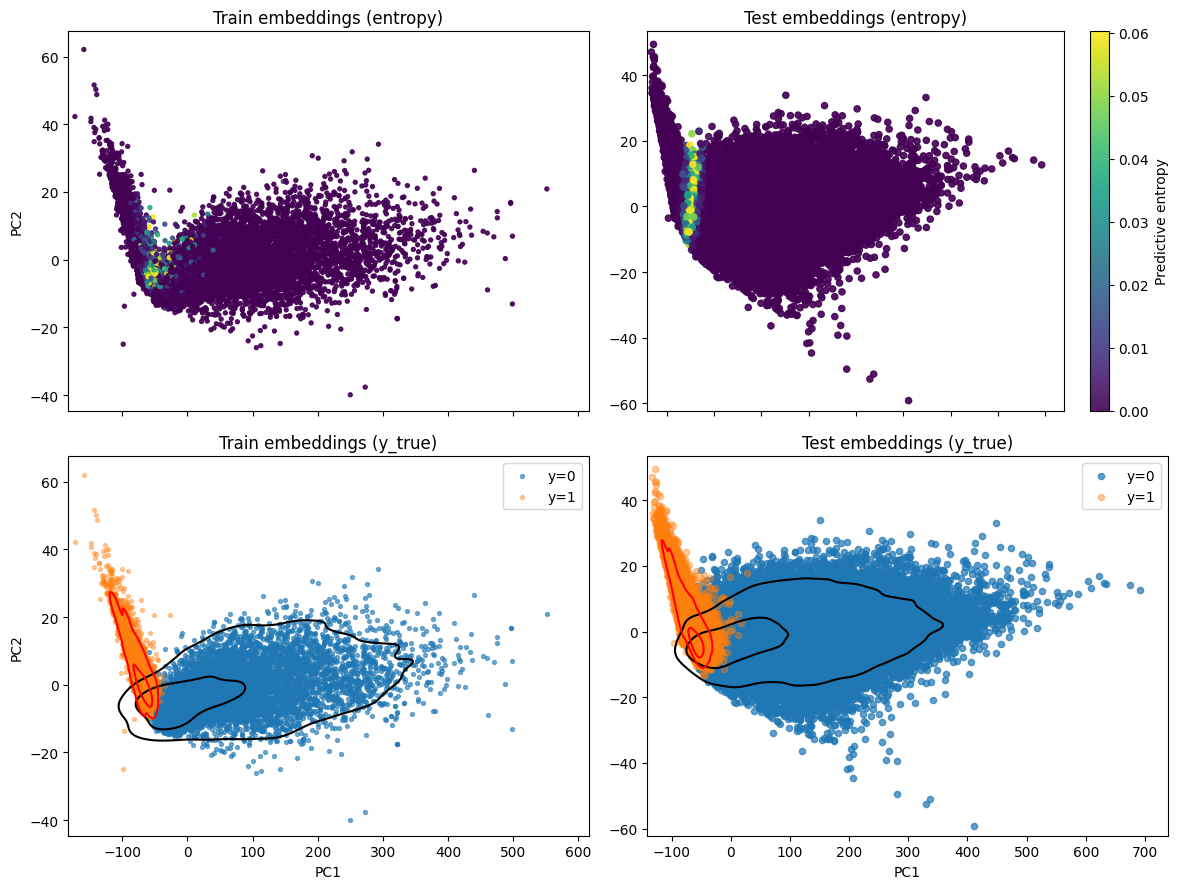

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex="col", sharey="col")

# =======================
# TOP ROW — your existing plots
# =======================
axes[0, 0].scatter(
    train_proj[:, 0],
    train_proj[:, 1],
    c=train_entropy,
    cmap="viridis",
    s=8,
    alpha=0.9
)
axes[0, 0].set_title("Train embeddings (entropy)")
axes[0, 0].set_ylabel("PC2")

sc = axes[0, 1].scatter(
    test_proj[:, 0],
    test_proj[:, 1],
    c=entropy,
    cmap="viridis",
    s=20,
    alpha=0.9
)
axes[0, 1].set_title("Test embeddings (entropy)")
plt.colorbar(sc, ax=axes[0, 1], label="Predictive entropy")

# =======================
# BOTTOM LEFT — Train PCA by y_true
# =======================
axes[1, 0].scatter(
    train_proj[train_results['y_true'] == 0, 0],
    train_proj[train_results['y_true'] == 0, 1],
    s=8,
    alpha=0.6,
    label="y=0"
)
axes[1, 0].scatter(
    train_proj[train_results['y_true'] == 1, 0],
    train_proj[train_results['y_true'] == 1, 1],
    s=8,
    alpha=0.4,
    label="y=1"
)
axes[1, 0].set_title("Train embeddings (y_true)")
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")
axes[1, 0].legend()

# =======================
# BOTTOM RIGHT — Test PCA by y_true
# =======================
axes[1, 1].scatter(
    test_proj[test_predictions['y_true'] == 0, 0],
    test_proj[test_predictions['y_true'] == 0, 1],
    s=20,
    alpha=0.7,
    label="y=0",
    
)
axes[1, 1].scatter(
    test_proj[test_predictions['y_true'] == 1, 0],
    test_proj[test_predictions['y_true'] == 1, 1],
    s=20,
    alpha=0.4,
    label="y=1",
)
axes[1, 1].set_title("Test embeddings (y_true)")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].legend()





import seaborn as sns

# Class 0
sns.kdeplot(
    x=train_proj[train_results["y_true"] == 0, 0],
    y=train_proj[train_results["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=0 density",
)

# Class 1
sns.kdeplot(
    x=train_proj[train_results["y_true"] == 1, 0],
    y=train_proj[train_results["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=1 density",
)





# Class 0
sns.kdeplot(
    x=test_proj[test_predictions["y_true"] == 0, 0],
    y=test_proj[test_predictions["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 1]
)

# Class 1
sns.kdeplot(
    x=test_proj[test_predictions["y_true"] == 1, 0],
    y=test_proj[test_predictions["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 1]
)

plt.tight_layout()
plt.show()


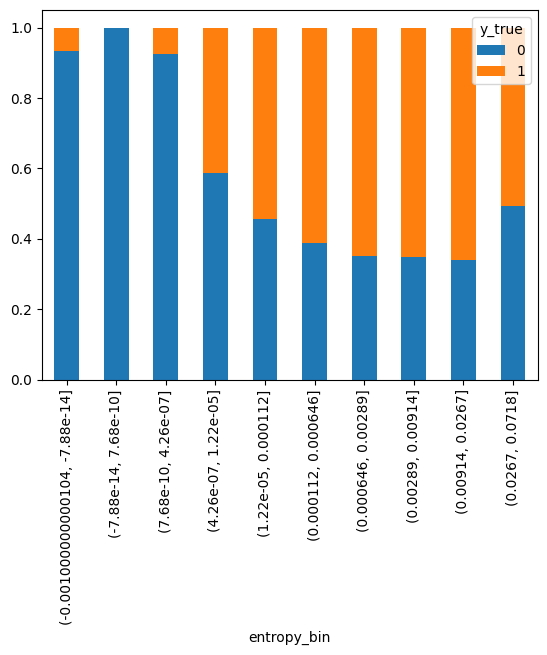

In [45]:
train_results["entropy_bin"] = pd.qcut(train_results["entropy"], 10)

pd.crosstab(
    train_results["entropy_bin"],
    train_results["y_true"],
    normalize="index"
).plot(kind="bar", stacked=True)
plt.show()

In [110]:
# out of sample (cosine similarity)

In [112]:
df = pd.read_csv("/Users/rezadoobary/Downloads/embeddings 2/train_6789_test_10/dropout/helpful-sweep-260_10_predictions_dropout.csv")

In [115]:
df['y_prob_std'].max()

0.5476843

# Train on 6,7,8,9 and Test on 11 - Full Analysis


In [3]:
import numpy as np
import pandas as pd

In [ ]:
# Load training embeddings from loops 6, 7, 8, 9 (trained on 6,7,8,9)
# These are the embeddings from the training set when model was trained on 6,7,8,9
embeddings_6 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_6/embeddings.npy")
embeddings_7 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_7/embeddings.npy")
embeddings_8 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_8/embeddings.npy")
embeddings_9 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_9/embeddings.npy")

# Stack training embeddings
train_embeddings = np.vstack([
    embeddings_6,
    embeddings_7,
    embeddings_8,
    embeddings_9
])

print(f"Training embeddings shape: {train_embeddings.shape}")
print(f"  - Loop 6: {embeddings_6.shape}")
print(f"  - Loop 7: {embeddings_7.shape}")
print(f"  - Loop 8: {embeddings_8.shape}")
print(f"  - Loop 9: {embeddings_9.shape}")


# Load test embeddings for loop 11 (full set, non-pos)
# Using train_678910_test_11 since that's what's available for test 11
test_embeddings = np.load("/Users/rezadoobary/Downloads/embeddings/train_678910_test_11/embeddings.npy")
test_predictions = pd.read_csv("/Users/rezadoobary/Downloads/embeddings/train_678910_test_11/devoted-sweep-14_11_predictions.csv")

print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"\nTest predictions columns: {test_predictions.columns.tolist()}")
print(f"\nTest predictions head:")
print(test_predictions.head())

# Load training predictions for loops 6, 7, 8, 9
prediction_files = [
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_6/helpful-sweep-260_6_predictions.csv",
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_7/helpful-sweep-260_7_predictions.csv",
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_8/helpful-sweep-260_8_predictions.csv",
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_9/helpful-sweep-260_9_predictions.csv"
]

import os

dfs = []
for p in prediction_files:
    df = pd.read_csv(p)
    # Extract loop number from directory name (e.g., "train_6789_test_6" -> 6)
    dir_name = os.path.basename(os.path.dirname(p))
    p_value = int(dir_name.split('_')[-1])  # Extract loop number from "test_X"
    df["loop"] = p_value
    dfs.append(df)

train_results = pd.concat(dfs, ignore_index=True)
print(f"Training predictions shape: {train_results.shape}")
print(f"\nTraining predictions columns: {train_results.columns.tolist()}")
print(f"\nTraining predictions head:")
print(train_results.head())

# Load dropout CSV information
dropout_predictions = pd.read_csv("/Users/rezadoobary/Downloads/embeddings_dropout/train_678910_test_11/dropout/devoted-sweep-14_11_predictions.csv")

print(f"Dropout predictions shape: {dropout_predictions.shape}")
print(f"\nDropout predictions columns: {dropout_predictions.columns.tolist()}")
print(f"\nDropout predictions head:")
print(dropout_predictions.head())
print(f"\nDropout statistics:")
print(dropout_predictions.describe())


# Merge dropout information with test predictions
# Assuming they have the same order and length
assert len(test_predictions) == len(dropout_predictions), "Mismatch in prediction lengths"

test_predictions_with_dropout = test_predictions.copy()
test_predictions_with_dropout['y_prob_mean'] = dropout_predictions['y_prob_mean']
test_predictions_with_dropout['y_prob_std'] = dropout_predictions['y_prob_std']
test_predictions_with_dropout['y_pred_dropout'] = dropout_predictions['y_pred']

print(f"Test predictions with dropout shape: {test_predictions_with_dropout.shape}")
print(f"\nColumns: {test_predictions_with_dropout.columns.tolist()}")
print(f"\nHead:")
print(test_predictions_with_dropout.head())

# Performance metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Basic performance
print("=== Test Performance (Loop 11) ===")
print(f"ROC-AUC: {roc_auc_score(test_predictions['y_true'], test_predictions['y_prob']):.4f}")
print(f"Accuracy: {accuracy_score(test_predictions['y_true'], test_predictions['y_pred']):.4f}")
print(f"Precision: {precision_score(test_predictions['y_true'], test_predictions['y_pred']):.4f}")
print(f"Recall: {recall_score(test_predictions['y_true'], test_predictions['y_pred']):.4f}")
print(f"F1-Score: {f1_score(test_predictions['y_true'], test_predictions['y_pred']):.4f}")

print(f"\n=== Training Performance (Loops 6,7,8,9) ===")
print(f"ROC-AUC: {roc_auc_score(train_results['y_true'], train_results['y_prob']):.4f}")
print(f"Accuracy: {accuracy_score(train_results['y_true'], train_results['y_pred']):.4f}")
print(f"Precision: {precision_score(train_results['y_true'], train_results['y_pred']):.4f}")
print(f"Recall: {recall_score(train_results['y_true'], train_results['y_pred']):.4f}")
print(f"F1-Score: {f1_score(train_results['y_true'], train_results['y_pred']):.4f}")

print(f"\n=== Dropout Statistics ===")
print(f"Max y_prob_std: {dropout_predictions['y_prob_std'].max():.6f}")
print(f"Mean y_prob_std: {dropout_predictions['y_prob_std'].mean():.6f}")
print(f"Median y_prob_std: {dropout_predictions['y_prob_std'].median():.6f}")
print(f"Std of y_prob_std: {dropout_predictions['y_prob_std'].std():.6f}")


# Summary of loaded data
print("=" * 60)
print("SUMMARY OF LOADED DATA")
print("=" * 60)
print(f"\nTraining Embeddings (Loops 6,7,8,9):")
print(f"  Shape: {train_embeddings.shape}")
print(f"  Total samples: {train_embeddings.shape[0]}")
print(f"  Embedding dimension: {train_embeddings.shape[1]}")

print(f"\nTest Embeddings (Loop 11, full set, non-pos):")
print(f"  Shape: {test_embeddings.shape}")
print(f"  Total samples: {test_embeddings.shape[0]}")
print(f"  Embedding dimension: {test_embeddings.shape[1]}")

print(f"\nTraining Predictions:")
print(f"  Shape: {train_results.shape}")
print(f"  Positive samples: {(train_results['y_true'] == 1).sum()}")
print(f"  Negative samples: {(train_results['y_true'] == 0).sum()}")

print(f"\nTest Predictions:")
print(f"  Shape: {test_predictions.shape}")
print(f"  Positive samples: {(test_predictions['y_true'] == 1).sum()}")
print(f"  Negative samples: {(test_predictions['y_true'] == 0).sum()}")

print(f"\nDropout Predictions:")
print(f"  Shape: {dropout_predictions.shape}")
print(f"  Columns: {dropout_predictions.columns.tolist()}")
print("=" * 60)





Training embeddings shape: (15599, 128)
  - Loop 6: (31, 128)
  - Loop 7: (164, 128)
  - Loop 8: (1432, 128)
  - Loop 9: (13972, 128)
Test embeddings shape: (1697302, 64)
Test predictions shape: (1697302, 3)

Test predictions columns: ['y_true', 'y_prob', 'y_pred']

Test predictions head:
   y_true        y_prob  y_pred
0       0  8.345743e-19       0
1       0  9.091197e-21       0
2       0  3.386519e-16       0
3       0  3.727300e-17       0
4       0  2.849526e-24       0


ValueError: invalid literal for int() with base 10: 'predictions'

In [ ]:
x